In [43]:
%load_ext autoreload
%autoreload 2

# First, import a few Python packages and landlab tools
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from scipy import stats
from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
import scipy.optimize
from scipy.optimize import curve_fit
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
mpl.rcParams['font.size'] = 8
import utils
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load analysis outputs from csv file

In [44]:
# load data 
excel_filename = 'information_loss_analysis_outputs.csv'
data = pd.read_csv(excel_filename)

### Plot degradation coefficient and line length change over time

We define the degradation coefficient $\phi$ as:

\begin{equation}

\phi = \frac{{mod(slope_{t0})}}{{mod(slope_{t})}}

\end{equation}

R1
R10
R2
R3
R4
R5
R6
R7
R8
R9


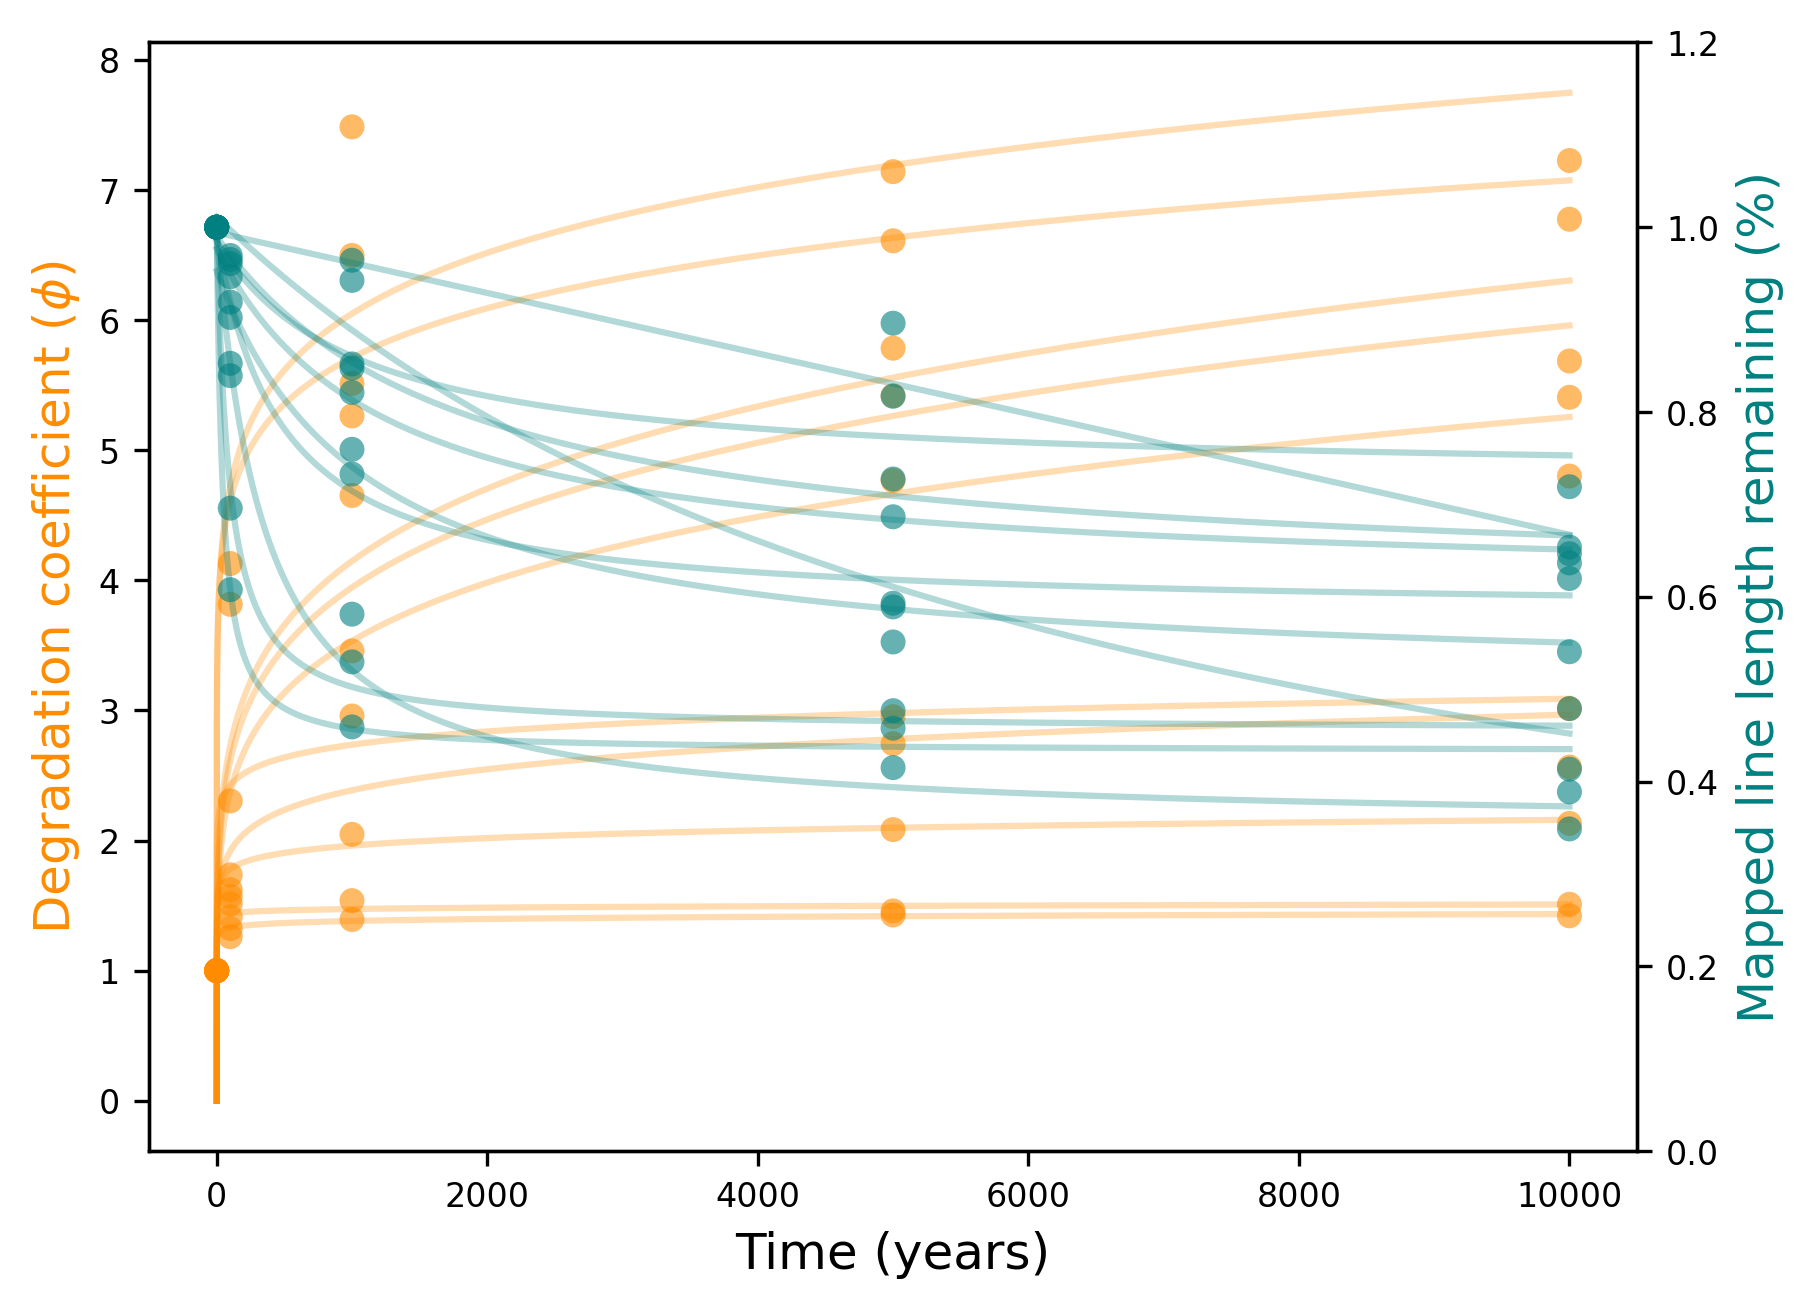

In [45]:
grouped = data.groupby('DEM ID')
fig, ax1 = plt.subplots(dpi=300)
ax2 = ax1.twinx()

for name, group in grouped:
    ax1.scatter(group['Time (years)'], group['Degradation coefficient'],c='darkorange',alpha=0.6,edgecolor='none')
    normalized_length = group['Length (m)'] / group['Length (m)'].iloc[0]
    ax2.scatter(group['Time (years)'], normalized_length, c='teal',alpha=0.6,edgecolor='none')  
    
    popt_deg, pcov_deg = curve_fit(utils.func_deg_coeff, group['Time (years)'], group['Degradation coefficient'])
    popt_line, pcov_line= curve_fit(utils.func_line_length, group['Time (years)'], normalized_length)

    x = np.linspace(min(group['Time (years)']),max(group['Time (years)']),10000)

    ax1.plot(x,utils.func_deg_coeff(x, *popt_deg),color='darkorange',alpha=0.3)
    ax2.plot(x,utils.func_line_length(x, *popt_line),color='teal',alpha=0.3)
    ax1.set_ylabel('Degradation coefficient ($\phi$)',c='darkorange',fontsize=12)
    ax1.set_xlabel('Time (years)',fontsize=12)
    ax2.set_ylabel('Mapped line length remaining (%)',c='teal',fontsize=12)
    ax2.set_ylim(0,1.2)
    print(name)

